In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tarfile
import scipy.io
import os
from urllib.request import urlretrieve
import io
import shutil
import torch

# clone YOLOv5 repository
! git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
# install dependencies as necessary (ignore errors)
! pip install -qr requirements.txt
! pip install -U ultralytics

dataset = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
labels = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"
urlretrieve(dataset, dataset.rsplit('/', 1)[-1])
urlretrieve(labels, labels.rsplit('/', 1)[-1])

tgz_file = dataset.rsplit('/', 1)[-1]
os.makedirs("/yolov_2/classes/")  # Changed the path from /model2/classes/ to /yolov_2/classes/
with tarfile.open(tgz_file, 'r:gz') as file:
    # Extract all files to the specified directory
    file.extractall('/yolov_2/classes/')  # Changed the path from /model2/classes/ to /yolov_2/classes/

mat = scipy.io.loadmat(labels.rsplit('/', 1)[-1])
y = pd.Series(mat['labels'][0])
# Shift the index by one position
y.index = y.index + 1
unique_labels = y.unique()
print(f"The count of unique classes is {len(unique_labels)}")

df = pd.DataFrame({"filename": sorted(os.listdir('/yolov_2/classes/jpg')),  "class": y.astype(str)})
print(df)

def organize_dataset():
    for index, class_label in y.items():
        image_filename = f"image_{index:05d}.jpg"
        source_path = os.path.join('/yolov_2/classes/jpg/', image_filename)
        target_path = os.path.join('/dataset', str(class_label), image_filename)
        os.makedirs(os.path.join('/dataset', str(class_label)), exist_ok=True)
        shutil.copyfile(source_path, target_path)

def locate_file_path(file_name, search_dir):
    for root, _, files in os.walk(search_dir):
        if file_name in files:
            return root
    return None

def relocate_images(image_list, source_dir, target_dir):
    for image in image_list:
        src_path = os.path.join(locate_file_path(image, source_dir), image)
        class_name = os.path.basename(os.path.dirname(src_path))
        dest_dir = os.path.join(target_dir, class_name)
        dest_path = os.path.join(dest_dir, image)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.move(src_path, dest_path)

def transfer_files(source_dir, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for dirpath, _, filenames in os.walk(source_dir):
        for filename in filenames:
            shutil.copy2(os.path.join(dirpath, filename), target_dir)

def count_files(directory):
    count = 0
    for _, _, files in os.walk(directory):
        count += len(files)
    return count

def aggregate_epoch_losses(i):
    name = 'flower_classifier' if i == 0 else f'flower_classifier{i+1}'
    train_loss_avg_epochs = {}
    val_loss_avg_epochs = {}
    val_acc_avg_epochs = {}

    train_val_df = pd.read_csv(f'/content/yolov5/runs/train-cls/{name}/results.csv')
    train_val_df.columns = train_val_df.columns.str.strip()

    for _, row in train_val_df.iterrows():
        epoch = int(row['epoch'])
        train_loss = row['train/loss']
        val_loss = row['val/loss']
        acc = row['metrics/accuracy_top1']

        train_loss_avg_epochs[epoch] = train_loss_avg_epochs.get(epoch, 0) + train_loss
        val_loss_avg_epochs[epoch] = val_loss_avg_epochs.get(epoch, 0) + val_loss
        val_acc_avg_epochs[epoch] = val_acc_avg_epochs.get(epoch, 0) + acc

    return train_loss_avg_epochs, val_loss_avg_epochs, val_acc_avg_epochs

def compute_loss_acc_averages(n, train_loss_avg_epochs, val_loss_avg_epochs, val_acc_avg_epochs):
    train_loss_avg_epochs = {epoch: loss / n for epoch, loss in train_loss_avg_epochs.items()}
    val_loss_avg_epochs = {epoch: loss / n for epoch, loss in val_loss_avg_epochs.items()}
    val_acc_avg_epochs = {epoch: acc / n for epoch, acc in val_acc_avg_epochs.items()}
    return train_loss_avg_epochs, val_loss_avg_epochs, val_acc_avg_epochs

def compute_correct_predictions(df_model, df_total):
    merged_df = df_model.merge(df_total[['filename', 'class']], left_on='image', right_on='filename', how='left')
    correct = (merged_df['max_class'] == merged_df['class']).sum()
    return correct

def purge_directories(to_del):
    for path in to_del:
        if os.path.isdir(path):
            print(f"delete path - {path}")
            shutil.rmtree(path)

def train_and_validate(df, n, num_epoch, seed, optimizer, lr, dropout, batch_size):
    if os.path.isdir(os.path.join(os.getcwd(), 'runs')):
        shutil.rmtree(os.path.join(os.getcwd(), 'runs'))

    test_accuracy = []

    for i in range(n):
        organize_dataset()
        train_df, val_test_df = train_test_split(df, test_size=0.5, stratify=df['class'], shuffle=True, random_state=seed)
        val_df, test_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df['class'], shuffle=True, random_state=seed)

        relocate_images(train_df['filename'], '/dataset', '/dataset/train')
        print(f"Number of training images: {count_files('/dataset/train')}")
        relocate_images(val_df['filename'], '/dataset', '/dataset/val')
        print(f"Number of validation images: {count_files('/dataset/val')}")
        relocate_images(test_df['filename'], '/dataset', '/test_dataset')
        print(f"Number of testing images: {count_files('/test_dataset')}")
        transfer_files('/test_dataset', '/test')

        !python classify/train.py --model yolov5s-cls.pt --data /dataset --epochs $num_epoch --pretrained yolov5s-cls.pt --name flower_classifier --lr0 $lr --seed "${seed}" --batch-size $batch_size

        train_loss_avg_epochs, val_loss_avg_epochs, val_acc_avg_epochs = aggregate_epoch_losses(i)

        name = 'flower_classifier' if i == 0 else f'flower_classifier{i+1}'
        weights_path = f"runs/train-cls/{name}/weights/best.pt"
        output = !python classify/predict.py --weights $weights_path --source /test

        data = []
        for line in output:
            if line.startswith('image'):
                parts = line.split()
                image_path = parts[2].replace('/test/', '').rstrip(':')
                max_class = parts[4]
                data.append({'image': image_path, 'max_class': max_class})

        df_model = pd.DataFrame(data)
        correct_pred = compute_correct_predictions(df_model, df)
        total_test_samples = df_model.shape[0]
        accuracy = correct_pred/total_test_samples
        print(f"Test accuracy cycle {i}: {round(accuracy * 100, 3)}%")
        test_accuracy.append(accuracy)
        purge_directories(['/dataset', '/test', '/test_dataset'])

    print(f"model accuracy = {round(np.mean(test_accuracy) * 100, 3)}%")
    return compute_loss_acc_averages(n, train_loss_avg_epochs, val_loss_avg_epochs, val_acc_avg_epochs)


Cloning into 'yolov5'...
remote: Enumerating objects: 17270, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 17270 (delta 0), reused 0 (delta 0), pack-reused 17265 (from 1)
Receiving objects: 100% (17270/17270), 16.11 MiB | 5.73 MiB/s, done.
Resolving deltas: 100% (11861/11861), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:

Number of training images: 4094
Number of validation images: 2047
Number of testing images: 2048
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-02-02 12:41:07.407176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738500067.676408    1426 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738500067.762419    1426 cuda_bla

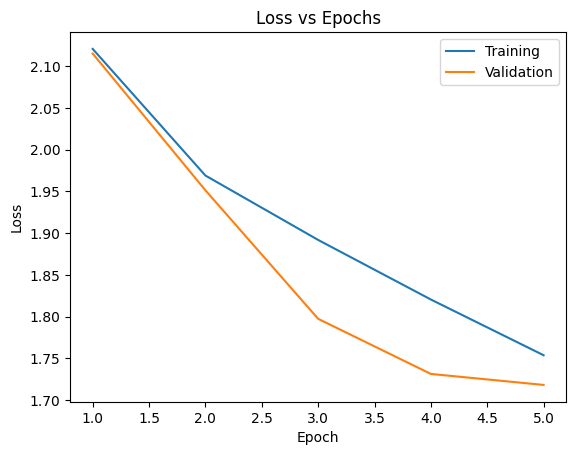

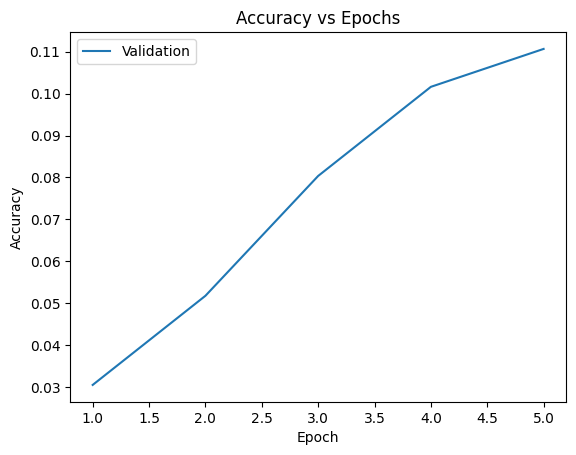

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

train_loss_avg, val_loss_avg, val_acc_avg = train_and_validate(df, n=2, num_epoch=5, seed=42, optimizer='ADAM', lr=0.001, dropout=0, batch_size=64)
print(f'train loss {train_loss_avg}')
print(f'val loss {val_loss_avg}')
print(f'val acc {val_acc_avg}')

plt.plot(np.array(list(train_loss_avg.keys())) + 1, list(train_loss_avg.values()), label='Training')
plt.plot(np.array(list(val_loss_avg.keys())) + 1, list(val_loss_avg.values()), label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

plt.plot(np.array(list(val_acc_avg.keys())) + 1, list(val_acc_avg.values()), label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()
